<a href="https://colab.research.google.com/github/RudrenduPaul/AI-Strategies-StockMarket/blob/master/Sandbox/Paul_Sandbox/01_1_b_Fed_Monthly_Pre_processing_multiple_vintages_lag_ffill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Module 1: Importing the libraries

import tensorflow as tf
from tensorflow import keras
keras = tf.keras

# Print all outputs in a code block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Importing the libraries
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from datetime import datetime, timedelta

from dateutil.relativedelta import relativedelta
from numpy import nan

import seaborn as sns
import math

# from tf.random import set_seed

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from keras.callbacks import ModelCheckpoint

# from keras.callbacks import ResetStatesCallback()

from keras.layers import Conv1D
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten,Dense
from keras.utils import to_categorical

# Paralelize operations 
# from pandarallel import pandarallel

import tensorflow as tf
from tensorflow import random
# from tensorflow.random import set_seed

# Set Seed

seed_global = 42
from numpy.random import seed
seed(seed_global)
import tensorflow
tensorflow.random.set_seed(seed_global)
# Copy paste this code snippet in every model code chunk 
seed(seed_global)
tensorflow.random.set_seed(seed_global)

from google.cloud import bigquery

In [2]:
#  Whether we are in Colab or not?
import sys
is_colab = 'google.colab' in sys.modules

if is_colab:
    from google.colab import auth
    auth.authenticate_user()

## Save to BQ

In [3]:
save_to_bq = True

## Import data

In [4]:
# %%bigquery gdp_quarterly_q_0

# SELECT *
# FROM `deep-nexus.imf_model_raw_data.Fed_real_time_vintage_data_monthly_2021_Feb_10`

# ORDER BY sasdate

###################################################
######## DOWNLOAD THE  MONTHLY DATA FROM BQ ######
###################################################

bucket_name = 'imf-temp'
project_id = "deep-nexus"
client = bigquery.Client(project_id)
dataset_id = "imf_model_raw_data"
table_id = "Fed_real_time_vintage_data_monthly_2021_Feb_10"


destination_uri = "gs://{}/{}".format(bucket_name, table_id+".csv")
dataset_ref = bigquery.DatasetReference(project_id, dataset_id)
table_ref = dataset_ref.table(table_id)

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    location="US",
)  # API request
extract_job.result()  # Waits for job to complete.

!gsutil -m cp gs://imf-temp/"$table_id".csv .

gdp_quarterly_q_0 = pd.read_csv(table_id+".csv", dtype='str')

Copying gs://imf-temp/Fed_real_time_vintage_data_monthly_2021_Feb_10.csv...
\ [1/1 files][140.8 MiB/140.8 MiB] 100% Done                                    
Operation completed over 1 objects/140.8 MiB.                                    


In [5]:
gdp_quarterly_q = pd.DataFrame(gdp_quarterly_q_0)

## Create a subset of data: Comment out later

# vintage_subset = ['1999-08-01', '1999-09-01', '1999-10-01', 
#                   '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', 
#                   '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01']

# gdp_quarterly_q = gdp_quarterly_q[gdp_quarterly_q['vintage'].isin(vintage_subset)]

print("\nTotal rows and columns in dataset:")
gdp_quarterly_q.shape

gdp_quarterly_q.head(3)


Total rows and columns in dataset:


(158799, 135)

,vintage,sasdate,RPI,W875RX1,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPMAT,IPMANSICS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,...,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,IPDCONGD,IPNCONGD,IPBUSEQ,IPDMAT,IPNMAT,IPB51222S,IPFUELS,USTPU,DPCERA3M086SBEA,HWI,HWIURATIO,WPSFD49207,WPSFD49502,WPSID61,WPSID62,BOGMBASE,TWEXAFEGSMTHx,date2,vintage2,ism1,ism2,ism3,ism4
0,1999-08-01,1959-01-01,1691.3,1758.5,198740.0,17583.0,34.431,33.836,33.225,37.314,35.084,32.264,80.2,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,292000.0,52408.0,20060.0,752.0,2957.0,16351.0,9108.0,7243.0,32348.0,3037.0,7887.0,2511.0,7974.0,39.6,2.5,40.1,1657.0,350.0,...,22.9,28.9,30.7,29.6,2.28,2.87,2.16,NaN,274.9,6476.0,12298.0,85.1,NaN,21.47,41.78,24.45,16.56,21.031,37.708,13.599,21.454,28.278,22.922,49.346,10790.0,22.397,1357.0,0.333579154,33.1,33.4,30.6,31.6,50463.0,NaN,-365,14457,64.4,69.0,70.7,60.8
1,1999-09-01,1959-01-01,1691.3,1758.5,198740.0,17583.0,34.431,33.836,33.225,37.314,35.084,32.264,80.2,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,292000.0,52408.0,20060.0,752.0,2957.0,16351.0,9108.0,7243.0,32348.0,3037.0,7887.0,2511.0,7974.0,39.6,2.5,40.1,1657.0,350.0,...,22.9,28.9,30.7,29.6,2.28,2.87,2.16,NaN,274.9,6476.0,12298.0,85.1,NaN,21.47,41.78,24.45,16.56,21.031,37.708,13.599,21.454,28.278,22.922,49.346,10790.0,22.397,1357.0,0.333579154,33.1,33.4,30.6,31.6,50463.0,NaN,-365,14488,64.4,69.0,70.7,60.8
2,1999-10-01,1959-01-01,1691.3,1758.5,198740.0,17583.0,34.431,33.836,33.225,37.314,35.084,32.264,80.2,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,292000.0,52408.0,20060.0,752.0,2957.0,16351.0,9108.0,7243.0,32348.0,3037.0,7887.0,2511.0,7974.0,39.6,2.5,40.1,1657.0,350.0,...,22.9,28.9,30.7,29.6,2.28,2.87,2.16,NaN,274.9,6476.0,12298.0,85.1,NaN,21.47,41.78,24.45,16.56,21.031,37.708,13.599,21.454,28.278,22.922,49.346,10790.0,22.397,1357.0,0.333579154,33.1,33.4,30.6,31.6,50463.0,NaN,-365,14518,64.4,69.0,70.7,60.8


In [6]:
gdp_quarterly_q.dtypes

for idx, colmn in enumerate(gdp_quarterly_q.columns):
    if colmn not in ['vintage', 'sasdate']:
        gdp_quarterly_q[colmn] = gdp_quarterly_q[colmn].astype(float)

gdp_quarterly_q.dtypes

vintage      object
sasdate      object
RPI          object
W875RX1      object
CMRMTSPLx    object
              ...  
vintage2     object
ism1         object
ism2         object
ism3         object
ism4         object
Length: 135, dtype: object

vintage       object
sasdate       object
RPI          float64
W875RX1      float64
CMRMTSPLx    float64
              ...   
vintage2     float64
ism1         float64
ism2         float64
ism3         float64
ism4         float64
Length: 135, dtype: object

In [7]:
gdp_quarterly_q.tail(3)

,vintage,sasdate,RPI,W875RX1,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPMAT,IPMANSICS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,...,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,IPDCONGD,IPNCONGD,IPBUSEQ,IPDMAT,IPNMAT,IPB51222S,IPFUELS,USTPU,DPCERA3M086SBEA,HWI,HWIURATIO,WPSFD49207,WPSFD49502,WPSID61,WPSID62,BOGMBASE,TWEXAFEGSMTHx,date2,vintage2,ism1,ism2,ism3,ism4
158796,2020-12-01,2020-11-01,17450.841,14118.0,NaN,546504.0,103.9818,100.2207,99.4549,103.9019,108.0173,101.0563,72.5705,160467.0,149732.0,6.7,23.2,2467.0,2413.0,5798.0,1857.0,3941.0,740500.0,142629.0,20237.0,573.3,7360.0,12253.0,7642.0,4611.0,122392.0,5653.3,15122.1,8730.0,21432.0,40.5,4.0,41.2,1547.0,135.0,...,334.450,259.451,237.742,248.365,25.66,29.54,23.06,76.9,21640.2,NaN,NaN,4612.0910,24.8047,111.704,86.451,98.496,120.924,123.9314,98.8952,93.0458,101.6198,101.6951,103.3740,96.0058,26870.0,118.478,NaN,NaN,204.6,214.6,196.7,187.8,5093100.0,105.6255,NaN,NaN,57.5,65.1,60.8,48.4
158797,2021-01-01,2020-11-01,17415.377,14088.2,1568472.0,544641.0,104.0882,100.5993,99.8521,104.2803,107.7697,101.2567,72.7144,160536.0,149809.0,6.7,23.0,2455.0,2404.0,5804.0,1875.0,3929.0,740500.0,142764.0,20259.0,575.2,7362.0,12271.0,7648.0,4623.0,122505.0,5658.4,15140.8,8731.0,21446.0,40.6,4.0,41.2,1578.0,164.0,...,334.450,259.451,237.742,248.365,25.68,29.54,23.07,76.9,21640.3,350127.01,734604.43,4612.1935,24.8047,111.694,86.248,98.488,120.961,123.2522,99.5332,93.5772,101.5447,101.6182,103.7241,95.9083,26880.0,118.123,6527.0,0.608408,204.6,214.6,196.7,187.8,5093100.0,105.6255,NaN,NaN,57.7,65.7,62.2,48.3
158798,2021-01-01,2020-12-01,17445.537,14056.6,NaN,540915.0,105.7244,102.1026,101.2530,105.9516,109.5649,102.1886,73.4060,160567.0,149830.0,6.7,23.4,2904.0,2222.0,5529.0,1572.0,3956.0,835500.0,142624.0,20352.0,577.3,7413.0,12309.0,7673.0,4636.0,122272.0,5683.5,15261.3,8743.0,21401.0,40.9,4.1,41.3,1669.0,107.0,...,334.742,260.403,238.901,249.409,25.78,29.64,23.12,80.7,21734.0,NaN,NaN,4689.5357,21.6803,112.169,86.501,99.193,121.391,123.5094,101.5504,94.1333,102.7739,101.8485,114.5813,95.6723,27071.0,117.398,NaN,NaN,206.4,217.1,199.6,191.9,5206600.0,103.3052,NaN,NaN,60.5,67.5,64.7,51.7


## Total Vintages in the dataset

In [8]:
gdp_quarterly_q['vintage'].nunique()

vintage_unique = gdp_quarterly_q['vintage'].unique()
np.shape(vintage_unique)
vintage_unique[0]
# vintage_unique[250]

print("\nAll vintages in the dataset:")
vintage_unique

258

(258,)

'1999-08-01'


All vintages in the dataset:


array(['1999-08-01', '1999-09-01', '1999-10-01', '1999-11-01',
       '1999-12-01', '2000-01-01', '2000-02-01', '2000-03-01',
       '2000-04-01', '2000-05-01', '2000-06-01', '2000-07-01',
       '2000-08-01', '2000-09-01', '2000-10-01', '2000-11-01',
       '2000-12-01', '2001-01-01', '2001-02-01', '2001-03-01',
       '2001-04-01', '2001-05-01', '2001-06-01', '2001-07-01',
       '2001-08-01', '2001-09-01', '2001-10-01', '2001-11-01',
       '2001-12-01', '2002-01-01', '2002-02-01', '2002-03-01',
       '2002-04-01', '2002-05-01', '2002-06-01', '2002-07-01',
       '2002-08-01', '2002-09-01', '2002-10-01', '2002-11-01',
       '2002-12-01', '2003-01-01', '2003-02-01', '2003-03-01',
       '2003-04-01', '2003-05-01', '2003-06-01', '2003-07-01',
       '2003-08-01', '2003-09-01', '2003-10-01', '2003-11-01',
       '2003-12-01', '2004-01-01', '2004-02-01', '2004-03-01',
       '2004-04-01', '2004-05-01', '2004-06-01', '2004-07-01',
       '2004-08-01', '2004-09-01', '2004-10-01', '2004-

In [9]:
gdp_quarterly_q['sasdate'].unique

<bound method Series.unique of 0         1959-01-01
1         1959-01-01
2         1959-01-01
3         1959-01-01
4         1959-01-01
             ...    
158794    2020-10-01
158795    2020-10-01
158796    2020-11-01
158797    2020-11-01
158798    2020-12-01
Name: sasdate, Length: 158799, dtype: object>

In [10]:
# gdp_quarterly_q.describe()

gdp_quarterly_q['vintage'].nunique()

258

## Drop unnecessary columns

In [11]:
gdp_quarterly_q = gdp_quarterly_q.drop(columns = ['date2', 'vintage2'])
gdp_quarterly_q.shape

(158799, 133)

## Missing values by columns

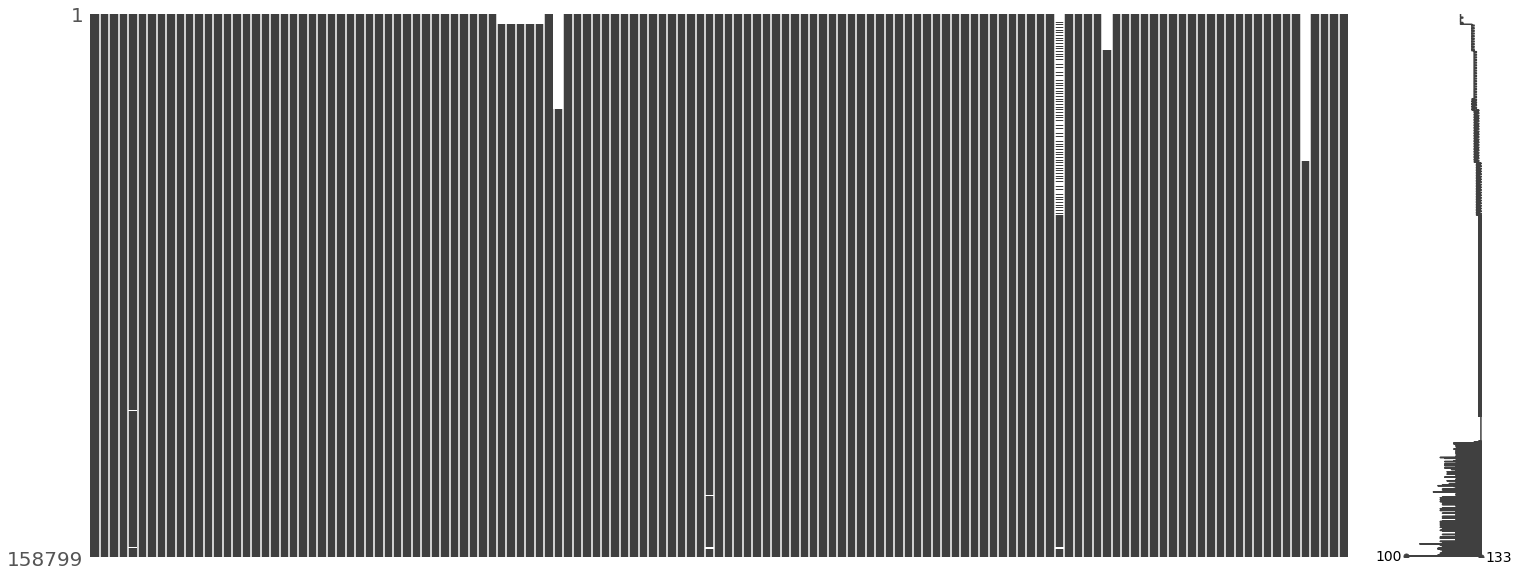

In [12]:
import missingno as msno  # visualize missing values in dataset 
msno.matrix(gdp_quarterly_q);

In [13]:
print("Column wise missing or null values:\n")
i = 0
cols_missing_data = []

for col in gdp_quarterly_q.columns:
    if gdp_quarterly_q[col].isnull().sum() == 0:
        i = i + 1
    if gdp_quarterly_q[col].isnull().sum() > 0:
        a = gdp_quarterly_q[col].isnull().sum()
#         print(col, a)
        cols_missing_data.append([col, a])
# print("\n")

print(len(cols_missing_data), "columns do not have any null values out of total", len(gdp_quarterly_q.columns), "columns")

# cols_missing_data

Column wise missing or null values:

42 columns do not have any null values out of total 133 columns


In [14]:
missing_cutoff_main_dataset = round(len(gdp_quarterly_q)*0.3)
print("\nMax missing values allowed per column:", missing_cutoff_main_dataset)
print("\n")
missing_cols_main_dataset = []

for i in range(len(cols_missing_data)):
    if cols_missing_data[i][1] > missing_cutoff_main_dataset:
        print(cols_missing_data[i])
        missing_cols_main_dataset.append(cols_missing_data[i][0])
        
print("\nCount of columns to be dropped since number of mising values above cutoff:", len(missing_cols_main_dataset))           


Max missing values allowed per column: 47640



Count of columns to be dropped since number of mising values above cutoff: 0


In [15]:
missing_cols_main_dataset

[]

In [16]:
# print(cols_missing_data[1][1], len(cols_missing_data))

cols_missing_data_arr = np.asarray(cols_missing_data)

Data dimensions before dropping columns: (158799, 133)
Data dimensions after dropping columns: (158799, 133)


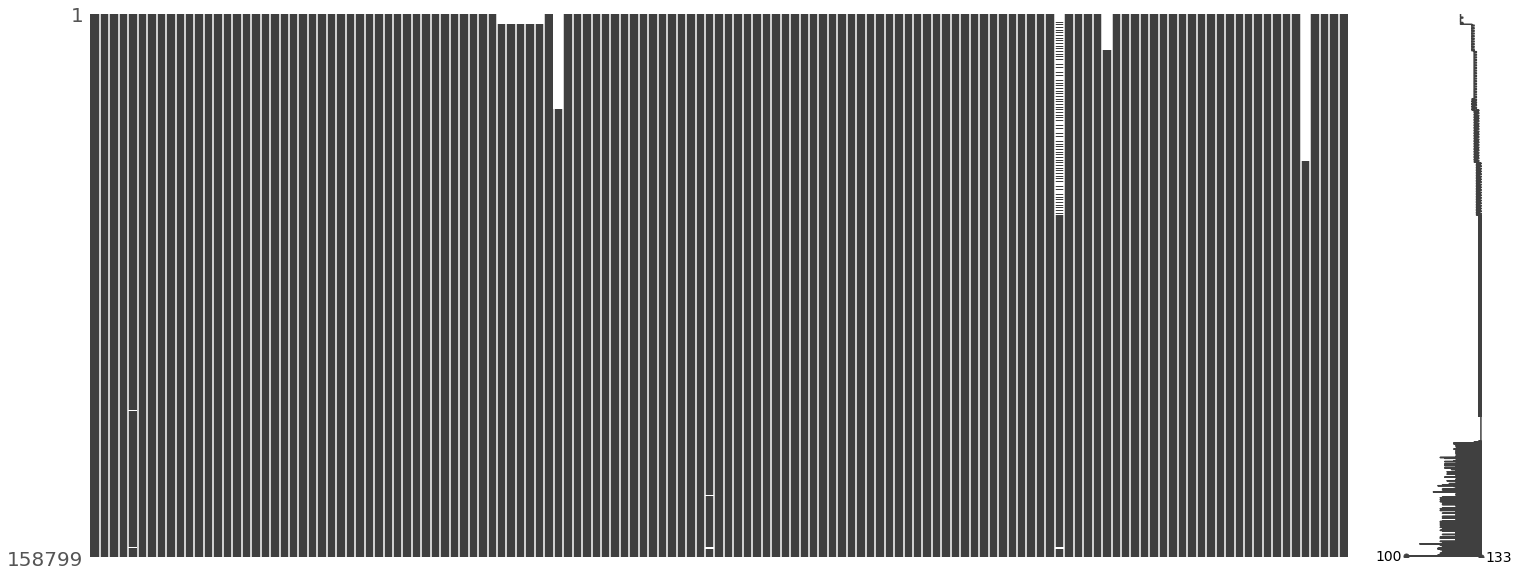

In [17]:
# Dropping clumns with # of missing values higher than cutoff

gdp_quarterly_q_copy = gdp_quarterly_q

print("Data dimensions before dropping columns:", gdp_quarterly_q.shape)

gdp_quarterly_q_copy = gdp_quarterly_q_copy.drop(missing_cols_main_dataset, axis = 1)

print("Data dimensions after dropping columns:", gdp_quarterly_q_copy.shape)

msno.matrix(gdp_quarterly_q_copy);

## Replace missing values in columns (with less than 30% missing data) with median values by vintage


After dropping rows with missing data


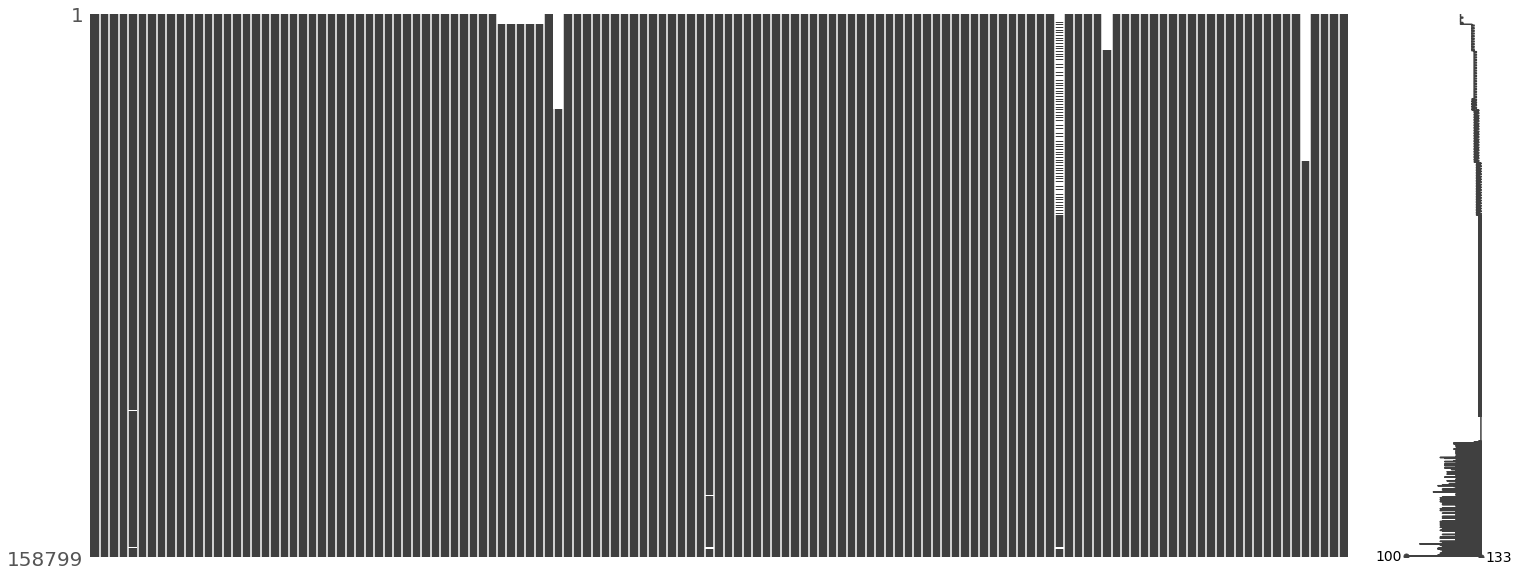

In [18]:
print("\nAfter dropping rows with missing data")
# for index, vintage_val in enumerate(gdp_quarterly_q_copy['vintage'].unique()):
# #     vintage_val = vintage_unique[l]
#     mask = (gdp_quarterly_q_copy['vintage'] == vintage_val)
    
#     try:
#     #     data_trans[mask].shape
        
# #         gdp_quarterly_q_copy[mask] = gdp_quarterly_q_copy[mask].ffill(axis = 0)
#         gdp_quarterly_q_copy[mask] = gdp_quarterly_q_copy[mask].fillna(gdp_quarterly_q_copy[mask].median())
#         # data_trans = data_trans.dropna()
# #         print("\n", index+1, "Vintage: ", vintage_val, "Dataset shape", gdp_quarterly_q_copy[mask].shape)
# #         print("Date range is from", gdp_quarterly_q_copy[mask]['sasdate'].min(), "to", gdp_quarterly_q_copy[mask]['sasdate'].max())
#     except:
#         print("Error for Vintage: ", index, vintage_val)

msno.matrix(gdp_quarterly_q_copy)

## Create artificial vintages for the period Jan-1959 to Aug-1999

In [19]:
gdp_quarterly_q_artif_vint = gdp_quarterly_q_copy.copy()

In [20]:
vintage_min = gdp_quarterly_q_artif_vint['vintage'].min()
vintage_min

sasdate_min = gdp_quarterly_q_artif_vint['sasdate'].min()
sasdate_min

df_vint_insert = gdp_quarterly_q_artif_vint[gdp_quarterly_q_artif_vint['vintage'] == vintage_min].reset_index(drop = True)
df_vint_insert_all = pd.DataFrame()

vintage_range = pd.date_range(sasdate_min,vintage_min, freq='MS').strftime("%Y-%m-%d").tolist()


for ind, vint in enumerate(vintage_range[:-1]):
#     print(ind, vint)
    df_vint_insert_loop = df_vint_insert.copy()
    df_vint_insert_loop['vintage'] = vint
#     print(ind, vint)
    if ind == 0:
        df_vint_insert_all = df_vint_insert_loop
    else:
        df_vint_insert_all = df_vint_insert_all.append(df_vint_insert_loop, ignore_index = True)
#     df_vint_insert_loop.

'1999-08-01'

'1959-01-01'

In [21]:
df_vint_insert.shape
len(vintage_range[:-1])

print("\nCheck # rows:\n")

print("Theoritical: ", df_vint_insert.shape[0] * len(vintage_range[:-1]))
print("\nActual in transformed dataset:", df_vint_insert_all.shape[0])

(487, 133)

487


Check # rows:

Theoritical:  237169

Actual in transformed dataset: 237169


### Corrected: Not Appending artifical vintages to existing dataset

In [22]:
# gdp_quarterly_q_artif_vint_append = df_vint_insert_all.append(gdp_quarterly_q_artif_vint, ignore_index = True)

gdp_quarterly_q_artif_vint_append = df_vint_insert_all ## .append(gdp_quarterly_q_artif_vint, ignore_index = True)

gdp_quarterly_q_artif_vint_append.shape

# gdp_quarterly_q_artif_vint_append.shape[0] + gdp_quarterly_q_artif_vint.shape[0]

(237169, 133)

## Processing data for Lag Structure 

### Step 1: Dropping rows with dates greater than vintage date

In [23]:
gdp_quarterly_q_lag = gdp_quarterly_q_artif_vint_append.copy()

def string_to_date(x):
    z = datetime.strptime(x, '%Y-%m-%d')
    return z

print(string_to_date('2020-11-01'))
    
gdp_quarterly_q_lag['vintage'] = gdp_quarterly_q_lag['vintage'].apply(string_to_date)
gdp_quarterly_q_lag['sasdate'] = gdp_quarterly_q_lag['sasdate'].apply(string_to_date)
gdp_quarterly_q_lag.head(3)
gdp_quarterly_q_lag.tail(3)
gdp_quarterly_q_lag.dtypes

2020-11-01 00:00:00


,vintage,sasdate,RPI,W875RX1,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPMAT,IPMANSICS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,...,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,IPDCONGD,IPNCONGD,IPBUSEQ,IPDMAT,IPNMAT,IPB51222S,IPFUELS,USTPU,DPCERA3M086SBEA,HWI,HWIURATIO,WPSFD49207,WPSFD49502,WPSID61,WPSID62,BOGMBASE,TWEXAFEGSMTHx,ism1,ism2,ism3,ism4
0,1959-01-01,1959-01-01,1691.3,1758.5,198740.0,17583.0,34.431,33.836,33.225,37.314,35.084,32.264,80.2,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,292000.0,52408.0,20060.0,752.0,2957.0,16351.0,9108.0,7243.0,32348.0,3037.0,7887.0,2511.0,7974.0,39.6,2.5,40.1,1657.0,350.0,...,33.3,38.1,22.9,28.9,30.7,29.6,2.28,2.87,2.16,NaN,274.9,6476.0,12298.0,85.1,NaN,21.47,41.78,24.45,16.56,21.031,37.708,13.599,21.454,28.278,22.922,49.346,10790.0,22.397,1357.0,0.333579,33.1,33.4,30.6,31.6,50463.0,NaN,64.4,69.0,70.7,60.8
1,1959-01-01,1959-02-01,1699.2,1769.2,201548.0,17712.0,35.105,34.293,33.513,37.588,36.195,32.857,81.4,67649.0,63684.0,5.9,15.5,1554.0,1164.0,1277.0,545.0,732.0,284000.0,52568.0,20121.0,743.0,2935.0,16443.0,9189.0,7254.0,32447.0,3042.0,7932.0,2513.0,7984.0,39.6,2.6,40.2,1667.0,346.0,...,33.3,38.1,23.0,28.9,30.7,29.6,2.29,2.88,2.17,NaN,276.0,6476.0,12298.0,85.6,NaN,21.48,41.81,24.47,16.57,21.142,38.068,13.781,22.442,28.773,22.859,48.674,10830.0,22.650,1421.0,0.358386,33.2,33.4,30.7,31.4,49805.0,NaN,66.9,70.5,70.3,62.5
2,1959-01-01,1959-03-01,1712.8,1785.5,204077.0,17860.0,35.611,34.500,33.677,37.588,37.135,33.371,82.5,68068.0,64267.0,5.6,15.3,1459.0,1093.0,1210.0,530.0,680.0,258000.0,52883.0,20313.0,743.0,2958.0,16612.0,9329.0,7283.0,32570.0,3051.0,7980.0,2523.0,8002.0,39.9,2.8,40.4,1620.0,330.0,...,33.2,38.3,23.0,28.9,30.7,29.6,2.31,2.87,2.19,NaN,277.4,6508.0,12349.0,85.3,NaN,21.49,41.86,24.46,16.59,21.556,37.888,13.930,23.326,29.206,23.015,49.906,10889.0,22.877,1524.0,0.400947,33.2,33.3,30.7,31.5,49733.0,NaN,67.1,70.2,71.2,62.3


,vintage,sasdate,RPI,W875RX1,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPMAT,IPMANSICS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,...,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,IPDCONGD,IPNCONGD,IPBUSEQ,IPDMAT,IPNMAT,IPB51222S,IPFUELS,USTPU,DPCERA3M086SBEA,HWI,HWIURATIO,WPSFD49207,WPSFD49502,WPSID61,WPSID62,BOGMBASE,TWEXAFEGSMTHx,ism1,ism2,ism3,ism4
237166,1999-07-01,1999-05-01,6509.2,6901.3,799412.0,247228.0,134.001,125.832,127.170,115.689,147.300,138.376,79.5,139019.0,133224.0,4.2,13.4,2467.0,1816.0,1523.0,794.0,729.0,306000.0,128162.0,25199.0,531.0,6239.0,18429.0,10971.0,7458.0,102963.0,6977.0,22748.0,7621.0,20077.0,41.0,4.6,41.7,1668.0,158.0,...,144.1,125.7,188.3,166.5,159.8,161.4,14.75,17.08,13.85,106.8,4120.9,105100.0,368600.0,1194.0,27.3765,104.60,93.34,103.41,107.65,113.728,102.786,116.320,119.333,102.689,103.219,104.653,25704.0,95.206,5088.0,0.877847,132.3,131.0,122.2,96.8,540620.0,116.234361,54.3,57.8,58.5,51.1
237167,1999-07-01,1999-06-01,6557.6,6921.2,805785.0,246841.0,134.198,125.653,127.009,115.851,148.185,138.570,79.4,139408.0,133432.0,4.3,14.5,2529.0,1736.0,1668.0,824.0,844.0,305000.0,128435.0,25180.0,527.0,6260.0,18393.0,10959.0,7434.0,103255.0,6989.0,22792.0,7639.0,20111.0,41.1,4.7,41.7,1571.0,159.0,...,143.8,125.7,188.5,166.5,159.6,161.3,14.84,17.15,13.94,107.3,4145.0,NaN,NaN,1210.3,24.1236,104.62,93.05,103.34,107.79,113.185,101.822,116.090,121.001,103.131,104.638,103.701,25751.0,95.453,4870.0,0.818350,132.4,131.3,122.6,97.0,544016.0,117.236131,55.8,59.4,61.6,51.3
237168,1999-07-01,1999-07-01,NaN,6930.1,NaN,248690.0,135.148,126.208,127.459,115.940,149.862,139.375,79.7,139254.0,133307.0,4.3,13.6,2680.0,1766.0,1505.0,787.0,718.0,296000.0,128745.0,25230.0,524.0,6282.0,18424.0,10998.0,7426.0,103515.0,7005.0,22883.0,7652.0,20127.0,41.1,4.8,41.9,1661.0,169.0,...,144.4,125.9,189.0,167.0,160.3,161.8,14.93,17.22,14.04,106.0,4163.6,NaN,NaN,1226.6,21.4866,104.86,92.97,103.65,108.07,113.892,100.921,117.242,123.496,102.464,107.164,104.838,25804.0,95.724,NaN,NaN,132.7,131.7,123.4,97.3,548817.0,117.580745,53.6,54.6,58.1,50.4


vintage          datetime64[ns]
sasdate          datetime64[ns]
RPI                     float64
W875RX1                 float64
CMRMTSPLx               float64
                      ...      
TWEXAFEGSMTHx           float64
ism1                    float64
ism2                    float64
ism3                    float64
ism4                    float64
Length: 133, dtype: object

In [24]:
print("Dimensions before dropping rows: ", gdp_quarterly_q_lag.shape)
gdp_quarterly_q_lag_1 = gdp_quarterly_q_lag[gdp_quarterly_q_lag['vintage'] > gdp_quarterly_q_lag['sasdate']]
print("Dimensions after dropping rows: ", gdp_quarterly_q_lag_1.shape)

Dimensions before dropping rows:  (237169, 133)
Dimensions after dropping rows:  (118341, 133)


In [25]:
gdp_quarterly_q_lag_1

,vintage,sasdate,RPI,W875RX1,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPMAT,IPMANSICS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,...,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,IPDCONGD,IPNCONGD,IPBUSEQ,IPDMAT,IPNMAT,IPB51222S,IPFUELS,USTPU,DPCERA3M086SBEA,HWI,HWIURATIO,WPSFD49207,WPSFD49502,WPSID61,WPSID62,BOGMBASE,TWEXAFEGSMTHx,ism1,ism2,ism3,ism4
487,1959-02-01,1959-01-01,1691.3,1758.5,198740.0,17583.0,34.431,33.836,33.225,37.314,35.084,32.264,80.2,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,292000.0,52408.0,20060.0,752.0,2957.0,16351.0,9108.0,7243.0,32348.0,3037.0,7887.0,2511.0,7974.0,39.6,2.5,40.1,1657.0,350.0,...,33.3,38.1,22.9,28.9,30.7,29.6,2.28,2.87,2.16,NaN,274.9,6476.0,12298.0,85.1,NaN,21.47,41.78,24.45,16.56,21.031,37.708,13.599,21.454,28.278,22.922,49.346,10790.0,22.397,1357.0,0.333579,33.1,33.4,30.6,31.6,50463.0,NaN,64.4,69.0,70.7,60.8
974,1959-03-01,1959-01-01,1691.3,1758.5,198740.0,17583.0,34.431,33.836,33.225,37.314,35.084,32.264,80.2,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,292000.0,52408.0,20060.0,752.0,2957.0,16351.0,9108.0,7243.0,32348.0,3037.0,7887.0,2511.0,7974.0,39.6,2.5,40.1,1657.0,350.0,...,33.3,38.1,22.9,28.9,30.7,29.6,2.28,2.87,2.16,NaN,274.9,6476.0,12298.0,85.1,NaN,21.47,41.78,24.45,16.56,21.031,37.708,13.599,21.454,28.278,22.922,49.346,10790.0,22.397,1357.0,0.333579,33.1,33.4,30.6,31.6,50463.0,NaN,64.4,69.0,70.7,60.8
975,1959-03-01,1959-02-01,1699.2,1769.2,201548.0,17712.0,35.105,34.293,33.513,37.588,36.195,32.857,81.4,67649.0,63684.0,5.9,15.5,1554.0,1164.0,1277.0,545.0,732.0,284000.0,52568.0,20121.0,743.0,2935.0,16443.0,9189.0,7254.0,32447.0,3042.0,7932.0,2513.0,7984.0,39.6,2.6,40.2,1667.0,346.0,...,33.3,38.1,23.0,28.9,30.7,29.6,2.29,2.88,2.17,NaN,276.0,6476.0,12298.0,85.6,NaN,21.48,41.81,24.47,16.57,21.142,38.068,13.781,22.442,28.773,22.859,48.674,10830.0,22.650,1421.0,0.358386,33.2,33.4,30.7,31.4,49805.0,NaN,66.9,70.5,70.3,62.5
1461,1959-04-01,1959-01-01,1691.3,1758.5,198740.0,17583.0,34.431,33.836,33.225,37.314,35.084,32.264,80.2,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,292000.0,52408.0,20060.0,752.0,2957.0,16351.0,9108.0,7243.0,32348.0,3037.0,7887.0,2511.0,7974.0,39.6,2.5,40.1,1657.0,350.0,...,33.3,38.1,22.9,28.9,30.7,29.6,2.28,2.87,2.16,NaN,274.9,6476.0,12298.0,85.1,NaN,21.47,41.78,24.45,16.56,21.031,37.708,13.599,21.454,28.278,22.922,49.346,10790.0,22.397,1357.0,0.333579,33.1,33.4,30.6,31.6,50463.0,NaN,64.4,69.0,70.7,60.8
1462,1959-04-01,1959-02-01,1699.2,1769.2,201548.0,17712.0,35.105,34.293,33.513,37.588,36.195,32.857,81.4,67649.0,63684.0,5.9,15.5,1554.0,1164.0,1277.0,545.0,732.0,284000.0,52568.0,20121.0,743.0,2935.0,16443.0,9189.0,7254.0,32447.0,3042.0,7932.0,2513.0,7984.0,39.6,2.6,40.2,1667.0,346.0,...,33.3,38.1,23.0,28.9,30.7,29.6,2.29,2.88,2.17,NaN,276.0,6476.0,12298.0,85.6,NaN,21.48,41.81,24.47,16.57,21.142,38.068,13.781,22.442,28.773,22.859,48.674,10830.0,22.650,1421.0,0.358386,33.2,33.4,30.7,31.4,49805.0,NaN,66.9,70.5,70.3,62.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237163,1999-07-01,1999-02-01,6479.5,6883.8,791427.0,243619.0,132.483,124.613,125.939,115.277,145.254,136.912,79.5,139271.0,133144.0,4.4,13.8,2601.0,1944.0,1550.0,766.0,784.0,291000.0,127730.0,25329.0,553.0,6238.0,18538.0,11027.0,7511.0,102401.0,6937.0,22648.0,7581.0,20054.0,41.0,4.5,41.6,1752.0,206.0,...,142.5,126.0,186.9,1

### Step 2: Replace values with missing data based on lag structure

#### Read Lag structure data

In [26]:
# %%bigquery Fred_data_dict_q_lag

# SELECT * FROM `deep-nexus.imf_model_raw_data.Fed_real_time_vintage_dict_monthly_2020_Nov_3`

bucket_name = 'imf-temp'
project_id = "deep-nexus"
client = bigquery.Client(project_id)
dataset_id = "imf_model_raw_data"
table_id = "Fed_real_time_vintage_dict_monthly_2020_Nov_3"


destination_uri = "gs://{}/{}".format(bucket_name, table_id+".csv")
dataset_ref = bigquery.DatasetReference(project_id, dataset_id)
table_ref = dataset_ref.table(table_id)

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    location="US",
)  # API request
extract_job.result()  # Waits for job to complete.

!gsutil -m cp gs://imf-temp/"$table_id".csv .

Fred_data_dict_q_lag = pd.read_csv(table_id+".csv", dtype='str')

Copying gs://imf-temp/Fed_real_time_vintage_dict_monthly_2020_Nov_3.csv...
/ [1/1 files][  6.1 KiB/  6.1 KiB] 100% Done                                    
Operation completed over 1 objects/6.1 KiB.                                      


In [27]:
Fred_data_dict_q_lag = pd.DataFrame(Fred_data_dict_q_lag)
# Fred_data_dict_m_lag.head(5)

## Filtering to relevant columsn and only values where lag > 1
Fred_data_dict_q_lag = Fred_data_dict_q_lag[['sasdate', 'Lag1', 'Lag2', 'Lag3']]
Fred_data_dict_q_lag[['Lag1', 'Lag2', 'Lag3']] = Fred_data_dict_q_lag[['Lag1', 'Lag2', 'Lag3']].astype(int)
Fred_data_dict_q_lag = Fred_data_dict_q_lag[(Fred_data_dict_q_lag['Lag1'] > 1) | (Fred_data_dict_q_lag['Lag2'] > 1)  | (Fred_data_dict_q_lag['Lag3'] > 1)]
# Fred_data_dict_m_lag = Fred_data_dict_m_lag[(Fred_data_dict_m_lag['Lag1'] + Fred_data_dict_m_lag['Lag2'] + Fred_data_dict_m_lag['Lag3'] > 3)]

Fred_data_dict_q_lag

print("\nTotal rows and columns in dataset:")
Fred_data_dict_q_lag.shape

,sasdate,Lag1,Lag2,Lag3
120,S_P_PE_ratio,3,1,2
121,HWI,2,2,2
122,HWIURATIO,2,2,2
123,ISRATIOx,2,2,2
124,CONSPI,2,2,2
125,CMRMTSPLx,2,2,2
126,BUSINVx,2,2,2
127,NONREVSL,2,2,2
128,DTCOLNVHFNM,2,2,2
129,DTCTHFNM,2,2,2



Total rows and columns in dataset:


(11, 4)

## Lag Structure Function: 

### Imputes missing values when sasdate is greater than (vintage date - lags (months) obtained from dictionary for specific columns)

In [28]:
def func_lag(df, dict1):

    # df1 = gdp_quarterly_q_lag_1.copy()
    # dict1 = Fred_data_dict_m_lag.copy()

    df1 = df

    for i in dict1.index:
        cols_dict = dict1.loc[i, 'sasdate']
        
        print(i, "Executing for column:", cols_dict)

        cols_subset = ['vintage', 'sasdate', cols_dict]
        
        try: 
            df2 = df1[cols_subset] 

            #     df1[cols_subset]

            for j in df2.index:
                if df2.loc[j, 'vintage'].month in [1, 4, 7, 10]:
                    lag = dict1.loc[i, 'Lag1']
                    vint_month = df2.loc[j, 'vintage'].month
                    date_offset = df2.loc[j, 'vintage'] - relativedelta(months=lag)

                    if df2.loc[j, 'sasdate'] >  date_offset:

                        df2.loc[j, cols_dict] = nan

    #                     print("Inserted Null values:", "Column: ", cols_dict, ", vintage:",df2.loc[j, 'vintage'], 
    #                           ', sasdate: ',df2.loc[j, 'sasdate'], ", Date Offset: ", date_offset)

            for j in df2.index:
                if df2.loc[j, 'vintage'].month in [2, 5, 8, 11]:
                    lag = dict1.loc[i, 'Lag2']
                    vint_month = df2.loc[j, 'vintage'].month
                    date_offset = df2.loc[j, 'vintage'] - relativedelta(months=lag)

                    if df2.loc[j, 'sasdate'] >  date_offset:

                        df2.loc[j, cols_dict] = nan

    #                     print("Inserted Null values:", "Column: ", cols_dict, ", vintage:", df2.loc[j, 'vintage'], 
    #                           ', sasdate: ', df2.loc[j, 'sasdate'], ", Date Offset: ", date_offset)

            for j in df2.index:
                if df2.loc[j, 'vintage'].month in [3, 6, 9, 12]:
                    lag = dict1.loc[i, 'Lag3']
                    vint_month = df2.loc[j, 'vintage'].month
                    date_offset = df2.loc[j, 'vintage'] - relativedelta(months=lag)

                    if df2.loc[j, 'sasdate'] >  date_offset:

                        df2.loc[j, cols_dict] = nan

    #                     print("Inserted Null values:", "Column: ", cols_dict, ", vintage:", df2.loc[j, 'vintage'], 
    #                           ', sasdate: ', df2.loc[j, 'sasdate'], ", Date Offset: ", date_offset)

            df1.loc[:, cols_subset] = df2 
        
        except:
            
            print("##############################################")
            print("Error while execuing for column:", cols_dict)
        
       
    
    return df1

In [29]:
gdp_quarterly_q_lag_2 = func_lag(gdp_quarterly_q_lag_1, Fred_data_dict_q_lag)

# gdp_quarterly_q_lag_2 = func_lag(gdp_quarterly_q_lag_1, Fred_data_dict_m_lag.loc[[120, 130], :])

120 Executing for column: S_P_PE_ratio


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


121 Executing for column: HWI
122 Executing for column: HWIURATIO
123 Executing for column: ISRATIOx
124 Executing for column: CONSPI
125 Executing for column: CMRMTSPLx
126 Executing for column: BUSINVx
127 Executing for column: NONREVSL
128 Executing for column: DTCOLNVHFNM
129 Executing for column: DTCTHFNM
130 Executing for column: S_P_div_yield


In [30]:
## Date to string conversion

def date_to_string(x):
    try:
        x = datetime.strptime(str(x[:10]), '%Y-%m-%d')
        x = datetime.strftime(x, '%Y-%m-%d')
        return(x)
    except:
        x = datetime.strftime(x, '%Y-%m-%d')
        return(x)
    
date_to_string('2019-12-01 00:00:00')  

'2019-12-01'

In [31]:
gdp_quarterly_q_lag_2['vintage'] = gdp_quarterly_q_lag_2['vintage'].apply(date_to_string)
gdp_quarterly_q_lag_2['sasdate'] = gdp_quarterly_q_lag_2['sasdate'].apply(date_to_string)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
gdp_quarterly_q_lag_2

,vintage,sasdate,RPI,W875RX1,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPMAT,IPMANSICS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,...,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,IPDCONGD,IPNCONGD,IPBUSEQ,IPDMAT,IPNMAT,IPB51222S,IPFUELS,USTPU,DPCERA3M086SBEA,HWI,HWIURATIO,WPSFD49207,WPSFD49502,WPSID61,WPSID62,BOGMBASE,TWEXAFEGSMTHx,ism1,ism2,ism3,ism4
487,1959-02-01,1959-01-01,1691.3,1758.5,NaN,17583.0,34.431,33.836,33.225,37.314,35.084,32.264,80.2,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,292000.0,52408.0,20060.0,752.0,2957.0,16351.0,9108.0,7243.0,32348.0,3037.0,7887.0,2511.0,7974.0,39.6,2.5,40.1,1657.0,350.0,...,33.3,38.1,22.9,28.9,30.7,29.6,2.28,2.87,2.16,NaN,274.9,NaN,NaN,85.1,NaN,21.47,41.78,24.45,16.56,21.031,37.708,13.599,21.454,28.278,22.922,49.346,10790.0,22.397,NaN,NaN,33.1,33.4,30.6,31.6,50463.0,NaN,64.4,69.0,70.7,60.8
974,1959-03-01,1959-01-01,1691.3,1758.5,198740.0,17583.0,34.431,33.836,33.225,37.314,35.084,32.264,80.2,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,292000.0,52408.0,20060.0,752.0,2957.0,16351.0,9108.0,7243.0,32348.0,3037.0,7887.0,2511.0,7974.0,39.6,2.5,40.1,1657.0,350.0,...,33.3,38.1,22.9,28.9,30.7,29.6,2.28,2.87,2.16,NaN,274.9,6476.0,12298.0,85.1,NaN,21.47,41.78,24.45,16.56,21.031,37.708,13.599,21.454,28.278,22.922,49.346,10790.0,22.397,1357.0,0.333579,33.1,33.4,30.6,31.6,50463.0,NaN,64.4,69.0,70.7,60.8
975,1959-03-01,1959-02-01,1699.2,1769.2,NaN,17712.0,35.105,34.293,33.513,37.588,36.195,32.857,81.4,67649.0,63684.0,5.9,15.5,1554.0,1164.0,1277.0,545.0,732.0,284000.0,52568.0,20121.0,743.0,2935.0,16443.0,9189.0,7254.0,32447.0,3042.0,7932.0,2513.0,7984.0,39.6,2.6,40.2,1667.0,346.0,...,33.3,38.1,23.0,28.9,30.7,29.6,2.29,2.88,2.17,NaN,276.0,NaN,NaN,85.6,NaN,21.48,41.81,24.47,16.57,21.142,38.068,13.781,22.442,28.773,22.859,48.674,10830.0,22.650,NaN,NaN,33.2,33.4,30.7,31.4,49805.0,NaN,66.9,70.5,70.3,62.5
1461,1959-04-01,1959-01-01,1691.3,1758.5,198740.0,17583.0,34.431,33.836,33.225,37.314,35.084,32.264,80.2,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,292000.0,52408.0,20060.0,752.0,2957.0,16351.0,9108.0,7243.0,32348.0,3037.0,7887.0,2511.0,7974.0,39.6,2.5,40.1,1657.0,350.0,...,33.3,38.1,22.9,28.9,30.7,29.6,2.28,2.87,2.16,NaN,274.9,6476.0,12298.0,85.1,NaN,21.47,41.78,24.45,16.56,21.031,37.708,13.599,21.454,28.278,22.922,49.346,10790.0,22.397,1357.0,0.333579,33.1,33.4,30.6,31.6,50463.0,NaN,64.4,69.0,70.7,60.8
1462,1959-04-01,1959-02-01,1699.2,1769.2,201548.0,17712.0,35.105,34.293,33.513,37.588,36.195,32.857,81.4,67649.0,63684.0,5.9,15.5,1554.0,1164.0,1277.0,545.0,732.0,284000.0,52568.0,20121.0,743.0,2935.0,16443.0,9189.0,7254.0,32447.0,3042.0,7932.0,2513.0,7984.0,39.6,2.6,40.2,1667.0,346.0,...,33.3,38.1,23.0,28.9,30.7,29.6,2.29,2.88,2.17,NaN,276.0,6476.0,12298.0,85.6,NaN,21.48,41.81,24.47,16.57,21.142,38.068,13.781,22.442,28.773,22.859,48.674,10830.0,22.650,1421.0,0.358386,33.2,33.4,30.7,31.4,49805.0,NaN,66.9,70.5,70.3,62.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237163,1999-07-01,1999-02-01,6479.5,6883.8,791427.0,243619.0,132.483,124.613,125.939,115.277,145.254,136.912,79.5,139271.0,133144.0,4.4,13.8,2601.0,1944.0,1550.0,766.0,784.0,291000.0,127730.0,25329.0,553.0,6238.0,18538.0,11027.0,7511.0,102401.0,6937.0,22648.0,7581.0,20054.0,41.0,4.5,41.6,1752.0,206.0,...,142.5,126.0,186.9,164.8,158.4,159.9,14.56,16.83,13.67,108.1

## Replace missing values in columns with median values by vintage

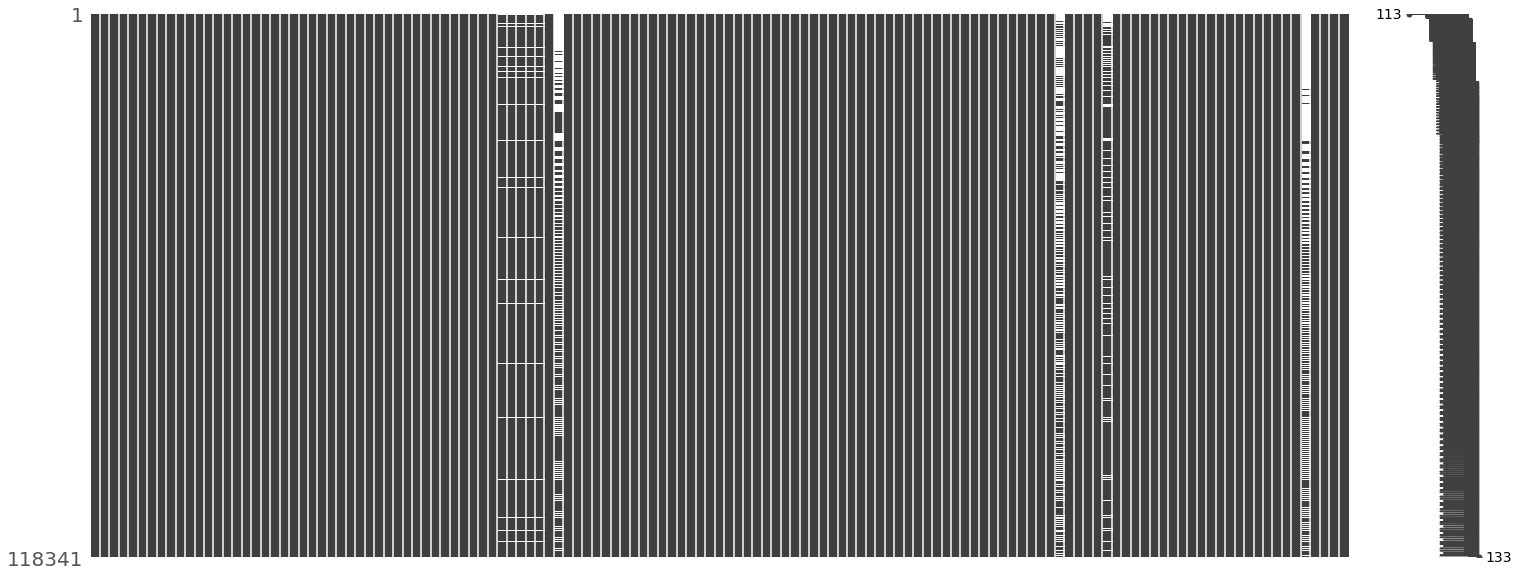

In [33]:
gdp_quarterly_q_lag_2_1 = gdp_quarterly_q_lag_2.copy()

# vint1 = gdp_quarterly_q_lag_2_1['vintage'].unique().tolist()

# # vint1

# for l in range(len(vint1)):
#     vintage_val = vint1[l]
#     mask = (gdp_quarterly_q_lag_2_1['vintage'] == vintage_val)
    
#     gdp_quarterly_q_lag_2_1[mask] = gdp_quarterly_q_lag_2_1[mask].ffill(axis = 0)
#     gdp_quarterly_q_lag_2_1[mask] = gdp_quarterly_q_lag_2_1[mask].fillna(gdp_quarterly_q_lag_2_1[mask].median())

# #     print(l+1, "Vintage: ", vintage_val, "Dataset shape", gdp_quarterly_q_lag_2_1[mask].shape)
    

# ## Zero fill imputation - when all of the values of the series are missing .fillna(0)    
# gdp_quarterly_q_lag_2_1 = gdp_quarterly_q_lag_2_1.fillna(0)

# gdp_quarterly_q_lag_2_1.shape

msno.matrix(gdp_quarterly_q_lag_2_1);

In [34]:
for i, sd in enumerate(gdp_quarterly_q_lag_2_1['sasdate'].unique()):
    if gdp_quarterly_q_lag_2_1[gdp_quarterly_q_lag_2_1['sasdate'] == sd].isnull().sum().sum() > 0:
        print("Sl No.", i, ", Sasdate:", sd, ", Null values:", gdp_quarterly_q_lag_2_1[gdp_quarterly_q_lag_2_1['sasdate'] == sd].isnull().sum().sum())

Sl No. 0 , Sasdate: 1959-01-01 , Null values: 4386
Sl No. 1 , Sasdate: 1959-02-01 , Null values: 4378
Sl No. 2 , Sasdate: 1959-03-01 , Null values: 4367
Sl No. 3 , Sasdate: 1959-04-01 , Null values: 4359
Sl No. 4 , Sasdate: 1959-05-01 , Null values: 3869
Sl No. 5 , Sasdate: 1959-06-01 , Null values: 4340
Sl No. 6 , Sasdate: 1959-07-01 , Null values: 4332
Sl No. 7 , Sasdate: 1959-08-01 , Null values: 4324
Sl No. 8 , Sasdate: 1959-09-01 , Null values: 4313
Sl No. 9 , Sasdate: 1959-10-01 , Null values: 4305
Sl No. 10 , Sasdate: 1959-11-01 , Null values: 3821
Sl No. 11 , Sasdate: 1959-12-01 , Null values: 4286
Sl No. 12 , Sasdate: 1960-01-01 , Null values: 1908
Sl No. 13 , Sasdate: 1960-02-01 , Null values: 1432
Sl No. 14 , Sasdate: 1960-03-01 , Null values: 1899
Sl No. 15 , Sasdate: 1960-04-01 , Null values: 1896
Sl No. 16 , Sasdate: 1960-05-01 , Null values: 1423
Sl No. 17 , Sasdate: 1960-06-01 , Null values: 1887
Sl No. 18 , Sasdate: 1960-07-01 , Null values: 1884
Sl No. 19 , Sasdate: 1

In [35]:
for i, sd in enumerate(gdp_quarterly_q_lag_2_1['vintage'].unique()):
    if gdp_quarterly_q_lag_2_1[gdp_quarterly_q_lag_2_1['vintage'] == sd].isnull().sum().sum()> 0:
        print("Sl No.", i, ", vintage:", sd, ", Null values:", gdp_quarterly_q_lag_2_1[gdp_quarterly_q_lag_2_1['vintage'] == sd].isnull().sum().sum())

Sl No. 0 , vintage: 1959-02-01 , Null values: 19
Sl No. 1 , vintage: 1959-03-01 , Null values: 30
Sl No. 2 , vintage: 1959-04-01 , Null values: 41
Sl No. 3 , vintage: 1959-05-01 , Null values: 46
Sl No. 4 , vintage: 1959-06-01 , Null values: 56
Sl No. 5 , vintage: 1959-07-01 , Null values: 67
Sl No. 6 , vintage: 1959-08-01 , Null values: 72
Sl No. 7 , vintage: 1959-09-01 , Null values: 83
Sl No. 8 , vintage: 1959-10-01 , Null values: 94
Sl No. 9 , vintage: 1959-11-01 , Null values: 99
Sl No. 10 , vintage: 1959-12-01 , Null values: 109
Sl No. 11 , vintage: 1960-01-01 , Null values: 120
Sl No. 12 , vintage: 1960-02-01 , Null values: 120
Sl No. 13 , vintage: 1960-03-01 , Null values: 125
Sl No. 14 , vintage: 1960-04-01 , Null values: 131
Sl No. 15 , vintage: 1960-05-01 , Null values: 131
Sl No. 16 , vintage: 1960-06-01 , Null values: 136
Sl No. 17 , vintage: 1960-07-01 , Null values: 142
Sl No. 18 , vintage: 1960-08-01 , Null values: 142
Sl No. 19 , vintage: 1960-09-01 , Null values: 147


### Check Data for each month (lag structure) for the year 2019

In [36]:
gdp_quarterly_q_lag_3 = gdp_quarterly_q_lag_2_1.copy()

## Append artificial vintages before Aug-1999 to data 

In [37]:
gdp_quarterly_q_lag_4 = gdp_quarterly_q_lag_3.append(gdp_quarterly_q_copy, ignore_index = True)

gdp_quarterly_q_lag_4.shape

(277140, 133)

## Create a subset of data for testing:

In [38]:
## Create a subset of data: Comment out later

vintage_subset = ['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01', '1959-05-01', '1959-06-01', 
                  '1959-07-01', '1959-08-01', '1959-09-01', '1959-10-01', '1959-11-01', '1959-12-01',
                  '1969-01-01', '1969-02-01', '1969-03-01', '1969-04-01', '1969-05-01', '1969-06-01', 
                  '1969-07-01', '1969-08-01', '1969-09-01', '1969-10-01', '1969-11-01', '1969-12-01', 
                  '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', 
                  '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01']

gdp_quarterly_q_lag_4_subset = gdp_quarterly_q_lag_4[gdp_quarterly_q_lag_4['vintage'].isin(vintage_subset)]

In [39]:
subset = 'N' ## Y or N for testing purposes only

if subset == 'Y':
    gdp_quarterly_q_imputed = gdp_quarterly_q_lag_4_subset.copy()

elif subset == 'N':
    gdp_quarterly_q_imputed = gdp_quarterly_q_lag_4.copy()

else:
    pass
    
vintage_unique = gdp_quarterly_q_imputed['vintage'].unique()

vintage_unique

array(['1959-02-01', '1959-03-01', '1959-04-01', '1959-05-01',
       '1959-06-01', '1959-07-01', '1959-08-01', '1959-09-01',
       '1959-10-01', '1959-11-01', '1959-12-01', '1960-01-01',
       '1960-02-01', '1960-03-01', '1960-04-01', '1960-05-01',
       '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01',
       '1960-10-01', '1960-11-01', '1960-12-01', '1961-01-01',
       '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01',
       '1961-06-01', '1961-07-01', '1961-08-01', '1961-09-01',
       '1961-10-01', '1961-11-01', '1961-12-01', '1962-01-01',
       '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01',
       '1962-06-01', '1962-07-01', '1962-08-01', '1962-09-01',
       '1962-10-01', '1962-11-01', '1962-12-01', '1963-01-01',
       '1963-02-01', '1963-03-01', '1963-04-01', '1963-05-01',
       '1963-06-01', '1963-07-01', '1963-08-01', '1963-09-01',
       '1963-10-01', '1963-11-01', '1963-12-01', '1964-01-01',
       '1964-02-01', '1964-03-01', '1964-04-01', '1964-

In [40]:
InteractiveShell.ast_node_interactivity = 'none'

In [41]:
InteractiveShell.ast_node_interactivity = "all"

# Importing data dictionary for input data transformation

In [42]:
# %%bigquery Fred_data_dict_q_col

# SELECT * FROM `deep-nexus.imf_model_raw_data.Fed_real_time_vintage_dict_monthly_2020_Nov_3`

bucket_name = 'imf-temp'
project_id = "deep-nexus"
client = bigquery.Client(project_id)
dataset_id = "imf_model_raw_data"
table_id = "Fed_real_time_vintage_dict_monthly_2020_Nov_3"


destination_uri = "gs://{}/{}".format(bucket_name, table_id+".csv")
dataset_ref = bigquery.DatasetReference(project_id, dataset_id)
table_ref = dataset_ref.table(table_id)

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    location="US",
)  # API request
extract_job.result()  # Waits for job to complete.

!gsutil -m cp gs://imf-temp/"$table_id".csv .

Fred_data_dict_q_col = pd.read_csv(table_id+".csv", dtype='str')

Copying gs://imf-temp/Fed_real_time_vintage_dict_monthly_2020_Nov_3.csv...
/ [1/1 files][  6.1 KiB/  6.1 KiB] 100% Done                                    
Operation completed over 1 objects/6.1 KiB.                                      


In [43]:
# %%bigquery transform_col_count

# SELECT A.transform, count(*)
# FROM `deep-nexus.imf_model_raw_data.Fed_real_time_vintage_dict_monthly_2020_Nov_3` A
# GROUP BY A.transform

In [44]:
# transform_col_count = pd.DataFrame(transform_col_count)
# transform_col_count

# transform_col_count['f0_'].sum()

In [45]:
gdp_quarterly_q_imputed.shape

gdp_quarterly_q_imputed.head(5)

(277140, 133)

,vintage,sasdate,RPI,W875RX1,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPMAT,IPMANSICS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,...,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,IPDCONGD,IPNCONGD,IPBUSEQ,IPDMAT,IPNMAT,IPB51222S,IPFUELS,USTPU,DPCERA3M086SBEA,HWI,HWIURATIO,WPSFD49207,WPSFD49502,WPSID61,WPSID62,BOGMBASE,TWEXAFEGSMTHx,ism1,ism2,ism3,ism4
0,1959-02-01,1959-01-01,1691.3,1758.5,NaN,17583.0,34.431,33.836,33.225,37.314,35.084,32.264,80.2,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,292000.0,52408.0,20060.0,752.0,2957.0,16351.0,9108.0,7243.0,32348.0,3037.0,7887.0,2511.0,7974.0,39.6,2.5,40.1,1657.0,350.0,...,33.3,38.1,22.9,28.9,30.7,29.6,2.28,2.87,2.16,NaN,274.9,NaN,NaN,85.1,NaN,21.47,41.78,24.45,16.56,21.031,37.708,13.599,21.454,28.278,22.922,49.346,10790.0,22.397,NaN,NaN,33.1,33.4,30.6,31.6,50463.0,NaN,64.4,69.0,70.7,60.8
1,1959-03-01,1959-01-01,1691.3,1758.5,198740.0,17583.0,34.431,33.836,33.225,37.314,35.084,32.264,80.2,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,292000.0,52408.0,20060.0,752.0,2957.0,16351.0,9108.0,7243.0,32348.0,3037.0,7887.0,2511.0,7974.0,39.6,2.5,40.1,1657.0,350.0,...,33.3,38.1,22.9,28.9,30.7,29.6,2.28,2.87,2.16,NaN,274.9,6476.0,12298.0,85.1,NaN,21.47,41.78,24.45,16.56,21.031,37.708,13.599,21.454,28.278,22.922,49.346,10790.0,22.397,1357.0,0.333579,33.1,33.4,30.6,31.6,50463.0,NaN,64.4,69.0,70.7,60.8
2,1959-03-01,1959-02-01,1699.2,1769.2,NaN,17712.0,35.105,34.293,33.513,37.588,36.195,32.857,81.4,67649.0,63684.0,5.9,15.5,1554.0,1164.0,1277.0,545.0,732.0,284000.0,52568.0,20121.0,743.0,2935.0,16443.0,9189.0,7254.0,32447.0,3042.0,7932.0,2513.0,7984.0,39.6,2.6,40.2,1667.0,346.0,...,33.3,38.1,23.0,28.9,30.7,29.6,2.29,2.88,2.17,NaN,276.0,NaN,NaN,85.6,NaN,21.48,41.81,24.47,16.57,21.142,38.068,13.781,22.442,28.773,22.859,48.674,10830.0,22.650,NaN,NaN,33.2,33.4,30.7,31.4,49805.0,NaN,66.9,70.5,70.3,62.5
3,1959-04-01,1959-01-01,1691.3,1758.5,198740.0,17583.0,34.431,33.836,33.225,37.314,35.084,32.264,80.2,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,292000.0,52408.0,20060.0,752.0,2957.0,16351.0,9108.0,7243.0,32348.0,3037.0,7887.0,2511.0,7974.0,39.6,2.5,40.1,1657.0,350.0,...,33.3,38.1,22.9,28.9,30.7,29.6,2.28,2.87,2.16,NaN,274.9,6476.0,12298.0,85.1,NaN,21.47,41.78,24.45,16.56,21.031,37.708,13.599,21.454,28.278,22.922,49.346,10790.0,22.397,1357.0,0.333579,33.1,33.4,30.6,31.6,50463.0,NaN,64.4,69.0,70.7,60.8
4,1959-04-01,1959-02-01,1699.2,1769.2,201548.0,17712.0,35.105,34.293,33.513,37.588,36.195,32.857,81.4,67649.0,63684.0,5.9,15.5,1554.0,1164.0,1277.0,545.0,732.0,284000.0,52568.0,20121.0,743.0,2935.0,16443.0,9189.0,7254.0,32447.0,3042.0,7932.0,2513.0,7984.0,39.6,2.6,40.2,1667.0,346.0,...,33.3,38.1,23.0,28.9,30.7,29.6,2.29,2.88,2.17,NaN,276.0,6476.0,12298.0,85.6,NaN,21.48,41.81,24.47,16.57,21.142,38.068,13.781,22.442,28.773,22.859,48.674,10830.0,22.650,1421.0,0.358386,33.2,33.4,30.7,31.4,49805.0,NaN,66.9,70.5,70.3,62.5


In [46]:
Fred_data_dict_q_col = pd.DataFrame(Fred_data_dict_q_col)
Fred_data_dict_q_col.head(5)
Fred_data_dict_q_col[['Transform', 'Lag1', 'Lag2', 'Lag3']] = Fred_data_dict_q_col[['Transform', 'Lag1', 'Lag2', 'Lag3']].astype(int)

print("\nTotal rows and columns in dataset:")
Fred_data_dict_q_col.shape

# Creating a copy of input data imported
data = gdp_quarterly_q_imputed

Fred_data_dict_q_col.iloc[0,1]

,sasdate,Transform,Description,Lag1,Lag2,Lag3
0,CES0600000007,1,Avg Weekly Hours : Goods-Producing,1,1,1
1,AWHMAN,1,Avg Weekly Hours : Manufacturing,1,1,1
2,COMPAPFFx,1,3-Month Commercial Paper Minus FEDFUNDS,1,1,1
3,TB3SMFFM,1,3-Month Treasury C Minus FEDFUNDS,1,1,1
4,TB6SMFFM,1,6-Month Treasury C Minus FEDFUNDS,1,1,1



Total rows and columns in dataset:


(131, 6)

1

In [47]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [48]:
data.head(3)

,vintage,sasdate,RPI,W875RX1,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPMAT,IPMANSICS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,...,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,IPDCONGD,IPNCONGD,IPBUSEQ,IPDMAT,IPNMAT,IPB51222S,IPFUELS,USTPU,DPCERA3M086SBEA,HWI,HWIURATIO,WPSFD49207,WPSFD49502,WPSID61,WPSID62,BOGMBASE,TWEXAFEGSMTHx,ism1,ism2,ism3,ism4
0,1959-02-01,1959-01-01,1691.3,1758.5,NaN,17583.0,34.431,33.836,33.225,37.314,35.084,32.264,80.2,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,292000.0,52408.0,20060.0,752.0,2957.0,16351.0,9108.0,7243.0,32348.0,3037.0,7887.0,2511.0,7974.0,39.6,2.5,40.1,1657.0,350.0,...,33.3,38.1,22.9,28.9,30.7,29.6,2.28,2.87,2.16,NaN,274.9,NaN,NaN,85.1,NaN,21.47,41.78,24.45,16.56,21.031,37.708,13.599,21.454,28.278,22.922,49.346,10790.0,22.397,NaN,NaN,33.1,33.4,30.6,31.6,50463.0,NaN,64.4,69.0,70.7,60.8
1,1959-03-01,1959-01-01,1691.3,1758.5,198740.0,17583.0,34.431,33.836,33.225,37.314,35.084,32.264,80.2,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,292000.0,52408.0,20060.0,752.0,2957.0,16351.0,9108.0,7243.0,32348.0,3037.0,7887.0,2511.0,7974.0,39.6,2.5,40.1,1657.0,350.0,...,33.3,38.1,22.9,28.9,30.7,29.6,2.28,2.87,2.16,NaN,274.9,6476.0,12298.0,85.1,NaN,21.47,41.78,24.45,16.56,21.031,37.708,13.599,21.454,28.278,22.922,49.346,10790.0,22.397,1357.0,0.333579,33.1,33.4,30.6,31.6,50463.0,NaN,64.4,69.0,70.7,60.8
2,1959-03-01,1959-02-01,1699.2,1769.2,NaN,17712.0,35.105,34.293,33.513,37.588,36.195,32.857,81.4,67649.0,63684.0,5.9,15.5,1554.0,1164.0,1277.0,545.0,732.0,284000.0,52568.0,20121.0,743.0,2935.0,16443.0,9189.0,7254.0,32447.0,3042.0,7932.0,2513.0,7984.0,39.6,2.6,40.2,1667.0,346.0,...,33.3,38.1,23.0,28.9,30.7,29.6,2.29,2.88,2.17,NaN,276.0,NaN,NaN,85.6,NaN,21.48,41.81,24.47,16.57,21.142,38.068,13.781,22.442,28.773,22.859,48.674,10830.0,22.650,NaN,NaN,33.2,33.4,30.7,31.4,49805.0,NaN,66.9,70.5,70.3,62.5


In [49]:
data_backup = data.copy()

for idx, colmn in enumerate(data.columns):
    if colmn not in ['vintage', 'sasdate']:
        data[colmn] = data[colmn].astype(float)
        
# data.info(verbose=True)

## Data Transformation Block

In [ ]:
# Change the input dataset here; Fred quarterly or monthly data

data_trans = pd.DataFrame(columns = data.columns)
data_trans['vintage'] = data['vintage']
data_trans['sasdate'] = data['sasdate']

# pandarallel.initialize()

# 1 quarter step ahead prediction
qa = 1

# Initializing counts of variables for each transformation type
a_1, a_2, a_3, a_4, a_5, a_6, a_7 = 0, 0, 0, 0, 0, 0, 0

# l = 0

for index, vintage_val in enumerate(data['vintage'].unique()):
#     vintage_val = vintage_unique[l]
    
#     print("Vintage Sl No.:", index+1)
#     print("Executing for vintage:", vintage_val)
    mask = (data_trans['vintage'] == vintage_val)

    for i in range(len(Fred_data_dict_q_col)):
        for j in range(len(data.columns)):
            if data.columns[j] == Fred_data_dict_q_col.iloc[i,0]:

#                 #### GDPC1 : No Transformation getting the levels
#                 if data.columns[j] == target_variable:                
#     #                 print(data.columns[j], Fred_data_dict_q_col.iloc[i,2])

#                     # 1: no transformation
#                     data_trans.iloc[:,j][mask] = data.iloc[:,j][mask]
#                     print("No tranformation for GDPC1")
                
                if Fred_data_dict_q_col.iloc[i,1] == 1:                
    #                 print(data.columns[j], Fred_data_dict_q_col.iloc[i,2])

                    # 1: no transformation
                    data_trans.iloc[:,j][mask] = data.iloc[:,j][mask]
                    a_1 = a_1 + 1  

                elif Fred_data_dict_q_col.iloc[i,1] == 2:
    #                 print(data.columns[j], Fred_data_dict_q_col.iloc[i,2])

                    # 2: Δxt
                    data_trans.iloc[:,j][mask] = data.iloc[:,j][mask].diff(qa)
                    a_2 = a_2 + 1                

                elif Fred_data_dict_q_col.iloc[i,1] == 3:
    #                 print(data.columns[j], Fred_data_dict_q_col.iloc[i,2])# 3: Δ2xt

                    # 3: Δ2xt
                    # quarter ahead prediction
                    data_trans.iloc[:,j][mask] = data.iloc[:,j][mask].diff(qa).diff(qa)
                    a_3 = a_3 + 1                

                elif Fred_data_dict_q_col.iloc[i,1] == 4:
    #                 print(data.columns[j], Fred_data_dict_q_col.iloc[i,2])

                    # 4: log(xt)
                    data_trans.iloc[:,j][mask] = np.log(data.iloc[:,j][mask])
                    a_4 = a_4 + 1                

                elif Fred_data_dict_q_col.iloc[i,1] == 5:
    #                 print(data.columns[j], Fred_data_dict_q_col.iloc[i,2])
                    
    #                 5: Δlog(xt)
                    data_trans.iloc[:,j][mask] = np.log(data.iloc[:,j][mask]).diff(qa)  
                    a_5 = a_5 + 1                
    #             
                elif Fred_data_dict_q_col.iloc[i,1] == 6:
    #                 print(data.columns[j], Fred_data_dict_q_col.iloc[i,2])

                    # 6: Δ2log(xt)
                    data_trans.iloc[:,j][mask] = np.log(data.iloc[:,j][mask]).diff(qa).diff(qa)
                    a_6 = a_6 + 1                

                elif Fred_data_dict_q_col.iloc[i,1] == 7:
    #                 print(data.columns[j], Fred_data_dict_q_col.iloc[i,2])

                    # 7: Δ(xt/x(t-1)-1)
                    data_trans.iloc[:,j][mask] = ((data.iloc[:,j][mask]/data.iloc[:,j][mask].shift(qa)) - 1).diff(qa)            
                    a_7 = a_7 + 1                
    #             else:
    #                     print("No transformation applied: ", data.columns[j])

#     print("Completed transformation for vintage:", vintage_val)

print("Imported dataset shape:", data.shape)
print("\nTransformed dataset shape:", data_trans.shape)


print("\nTransformation # 1: ", a_1, "vs Actual in dataset: ", 11*data_trans['vintage'].nunique())
print("Transformation # 2: ", a_2, "vs Actual in dataset: ", 19*data_trans['vintage'].nunique())
print("Transformation # 3: ", a_3, "vs Actual in dataset: ", 0*data_trans['vintage'].nunique())
print("Transformation # 4: ", a_4, "vs Actual in dataset: ", 10*data_trans['vintage'].nunique() )
print("Transformation # 5: ", a_5, "vs Actual in dataset: ", 52*data_trans['vintage'].nunique())
print("Transformation # 6: ", a_6, "vs Actual in dataset: ", 34*data_trans['vintage'].nunique())
print("Transformation # 7: ", a_7, "vs Actual in dataset: ", 1*data_trans['vintage'].nunique())

# transform_col_count

In [ ]:
print("Total vintages:")
data_trans['vintage'] .nunique()

data_trans.shape

data_trans.head(3)

data_trans.tail(3)

In [ ]:
data_trans['vintage'] = data_trans['vintage'].apply(date_to_string)
data_trans['sasdate'] = data_trans['sasdate'].apply(date_to_string)

In [ ]:
msno.matrix(data_trans);

## Replace missing values in columns with forward fill, median, 0 values by vintage

In [ ]:
data_trans_imputation_backup = data_trans

vint1 = data_trans['vintage'].unique().tolist()

# vint1

for l in range(len(vint1)):
  vintage_val = vint1[l]
  mask = (data_trans['vintage'] == vintage_val)
  
  data_trans[mask] = data_trans[mask].ffill(axis = 0)
  data_trans[mask] = data_trans[mask].fillna(data_trans[mask].median())

#     print(l+1, "Vintage: ", vintage_val, "Dataset shape", gdp_quarterly_q_lag_2_1[mask].shape)
    
## Zero fill imputation - when all of the values of the series are missing .fillna(0)    
data_trans = data_trans.fillna(0)
    
data_trans.shape

msno.matrix(data_trans);

## Check Null values by sasdate

In [ ]:
data_trans.head(3)

print("Null values by date: ")

for i, sd in enumerate(data_trans['sasdate'].unique()):
    if data_trans[data_trans['sasdate'] == sd].isnull().sum().sum() > 0:
        print("Sl No.", i, ", Sasdate:", sd, ", Null values:", data_trans[data_trans['sasdate'] == sd].isnull().sum().sum())
        
# for i, sd in enumerate(data_trans['vintage'].unique()):
#     if data_trans[data_trans['vintage'] == sd].isnull().sum().sum() > 0:
#         print("Sl No.", i, ", vintage:", sd, ", Null values:", data_trans[data_trans['vintage'] == sd].isnull().sum().sum())        

## Drop dates with missing values

In [ ]:
drop_sasdate = ['1959-01-01', '1959-02-01', '1959-03-01']

data_trans_1 = data_trans[~data_trans['sasdate'].isin(drop_sasdate)]

In [ ]:
for i, sd in enumerate(data_trans_1['sasdate'].unique()):
    if data_trans_1[data_trans_1['sasdate'] == sd].isnull().sum().sum() > 0:
        print("Sl No.", i, ", Sasdate:", sd, ", Null values:", data_trans_1[data_trans_1['sasdate'] == sd].isnull().sum().sum())

In [ ]:
for i, sd in enumerate(data_trans_1['vintage'].unique()):
    if data_trans_1[data_trans_1['vintage'] == sd].isnull().sum().sum() > 0:
        print("Sl No.", i, ", vintage:", sd, ", Null values:", data_trans_1[data_trans_1['vintage'] == sd].isnull().sum().sum())

In [ ]:
InteractiveShell.ast_node_interactivity = 'all'

## Missing values & columns in transformed dataset

In [ ]:
msno.matrix(data_trans_1);

In [ ]:
# type(data_trans)

### data_trans_1 = data_trans.copy()
data_trans_1.dtypes
data_trans_1.head(10)

## Output Column

In [ ]:
# Outcome vaiable (Column Name) = ngdp_r_sa_pcha
target_variable = "GDPC1"

## No Sequential train-test split

In [ ]:
dataset = data_trans_1.copy()
dataset.dtypes


dataset['sasdate'] = dataset['sasdate'].astype(str)

dataset['vintage'] = dataset['vintage'].apply(date_to_string)

dataset.index = dataset['sasdate']
print("\n Full Dataset Set \n")
dataset.shape
dataset.head(3)
dataset.tail(3)

## Saving data in bq table with date created 

In [ ]:
## Saving to table with date created

if save_to_bq:
    dataset.to_gbq('imf_model_raw_data.fed_m_train_test_vintages_2021_Feb_10_ffill', 'deep-nexus', if_exists='replace')

## Saving data in bq table with generic name 

In [ ]:
# Saving to table with generic name 

if save_to_bq:
    dataset.to_gbq('imf_model_raw_data.fed_m_train_test_vintages_lag_struct_ffill', 'deep-nexus', if_exists='replace')

In [ ]:
# %%bigquery fed_q_train_test_set

# SELECT *
# FROM `deep-nexus.imf_model_raw_data.fed_m_train_test_vintages_2021_Feb_10_ffill`

###################################################
######## DOWNLOAD THE MONTHLY DATA FROM BQ ######
###################################################

bucket_name = 'imf-temp'
project_id = "deep-nexus"
client = bigquery.Client(project_id)
dataset_id = "imf_model_raw_data"
table_id = "fed_m_train_test_vintages_2021_Feb_10_ffill"


destination_uri = "gs://{}/{}".format(bucket_name, table_id+".csv")
dataset_ref = bigquery.DatasetReference(project_id, dataset_id)
table_ref = dataset_ref.table(table_id)

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    location="US",
)  # API request
extract_job.result()  # Waits for job to complete.

!gsutil -m cp gs://imf-temp/"$table_id".csv .

fed_q_train_test_set = pd.read_csv(table_id+".csv", dtype='str')

In [ ]:
# # Saving to table with generic name 

# if save_to_bq:
#     fed_q_train_test_set.to_gbq('imf_model_raw_data.fed_m_train_test_vintages_lag_struct_ffill', 'deep-nexus', if_exists='replace')

In [ ]:
print("\n Full Dataset")
print("\nTotal rows and columns in saved full dataset:", fed_q_train_test_set.shape)

fed_q_train_test_set = pd.DataFrame(fed_q_train_test_set)
fed_q_train_test_set.head(3)

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# %%bigquery min_max_sasdate_fed_q_train_test_set

# SELECT min(vintage) as min_vintage, max(vintage) as max_vintage, 
# min(sasdate) as min_date, max(sasdate) as max_date 
# FROM `deep-nexus.imf_model_raw_data.fed_m_train_test_vintages_2021_Feb_10_ffill`

In [ ]:
# print("Full Dataset: Train and test date: Min and max date\n")
# min_max_sasdate_fed_q_train_test_set = pd.DataFrame(min_max_sasdate_fed_q_train_test_set)
# min_max_sasdate_fed_q_train_test_set.head(3)

## Sample Code for filtering null value by vintage and by date

In [ ]:
for i, sd in enumerate(fed_q_train_test_set['vintage'].unique()):
    if fed_q_train_test_set[fed_q_train_test_set['vintage'] == sd].isnull().sum().sum() > 0:
        print("Sl No.", i, ", vintage:", sd, ", Null values:", fed_q_train_test_set[fed_q_train_test_set['vintage'] == sd].isnull().sum().sum())

In [ ]:
for i, sd in enumerate(fed_q_train_test_set['sasdate'].unique()):
    if fed_q_train_test_set[fed_q_train_test_set['sasdate'] == sd].isnull().sum().sum() > 0:
        print("Sl No.", i, ", sasdate:", sd, ", Null values:", fed_q_train_test_set[fed_q_train_test_set['sasdate'] == sd].isnull().sum().sum())